<a href="https://colab.research.google.com/github/kxenopoulou/xenopoulos_dialectical-paradoxes-XEPTQLRI/blob/main/bitcoin_backtest_2021_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔄 ΒΗΜΑ 1: ΙΣΤΟΡΙΚΟ BACKTESTING - ΕΚΤΕΛΕΣΗ

📥 Λήψη ιστορικών δεδομένων Bitcoin...
   ✓ Λήφθηκαν 1827 ημέρες δεδομένων
   ✓ Από: 13/02/2021
   ✓ Έως: 13/02/2026

------------------------------------------------------------
📊 ΕΚΤΕΛΕΣΗ BACKTEST...
------------------------------------------------------------

📈 ΑΠΟΤΕΛΕΣΜΑΤΑ BACKTEST

📊 ΣΥΝΟΠΤΙΚΑ ΣΤΑΤΙΣΤΙΚΑ:
   • Σύνολο προβλέψεων: 1826
   • Σωστή κατεύθυνση: 50.33%
   • Μέση διαλεκτική δύναμη: 0.231
   • Μέσο XEPTQLRI: 133.02


📊 ΑΝΑΛΥΣΗ ΑΝΑ ΣΤΑΔΙΟ:
      direction_correct       xeptqlri
                   mean count     mean
stage                                 
2                 0.497   376    0.731
3                 0.512    43    3.728
4                 0.700    20    5.960
6                 0.502  1387  174.726

📈 Δημιουργία γραφημάτων...


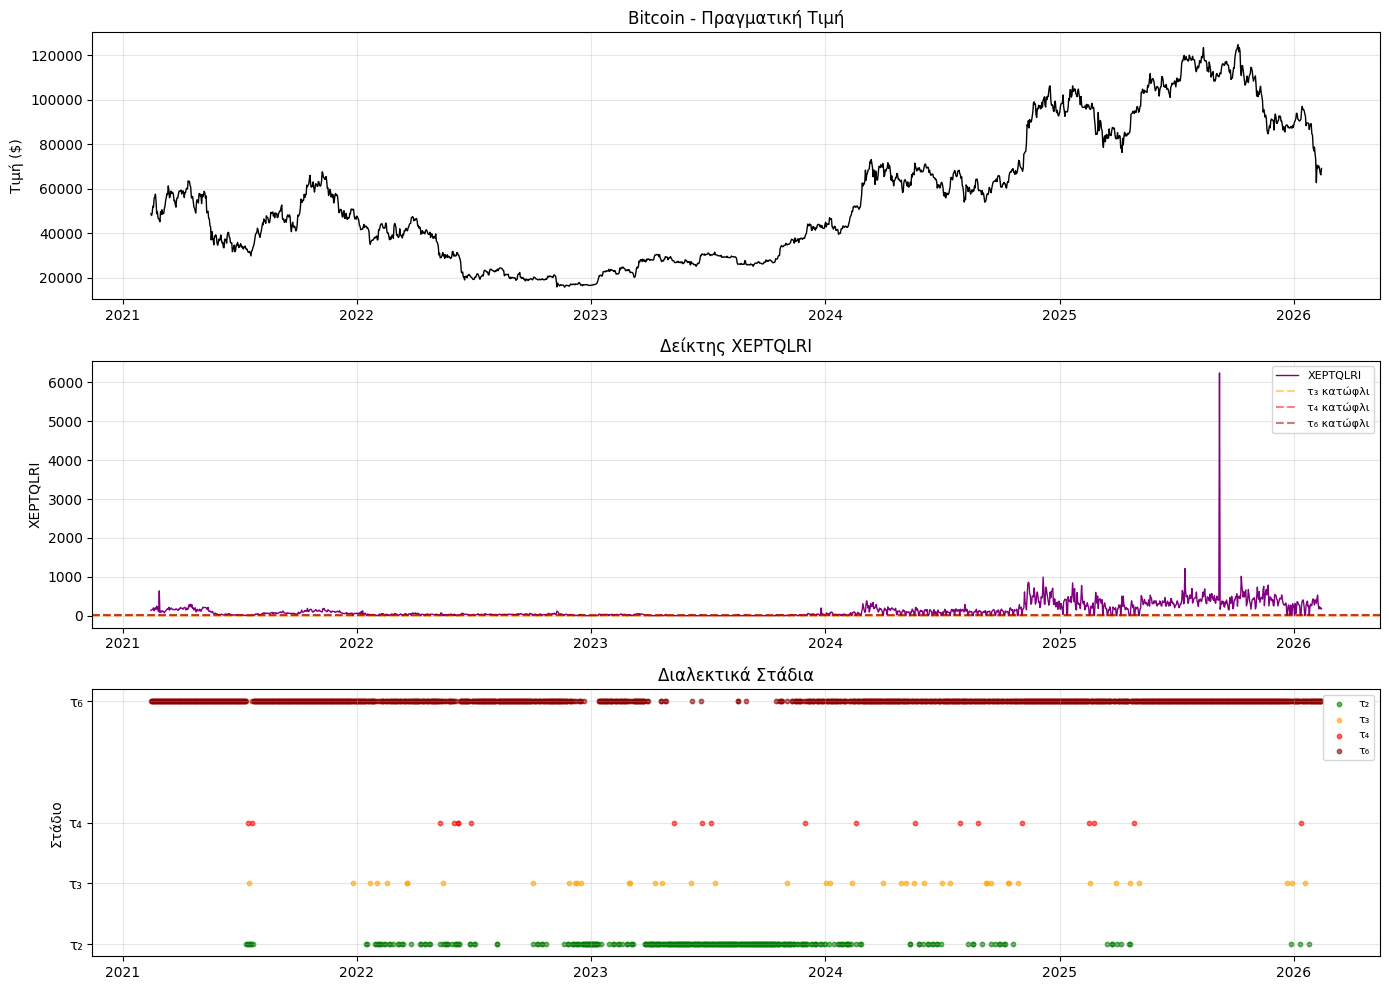


✅ ΒΗΜΑ 1 ΟΛΟΚΛΗΡΩΘΗΚΕ


In [2]:
# ============================================================================
# ΒΗΜΑ 1: ΙΣΤΟΡΙΚΟ BACKTESTING ΤΟΥ ΣΥΣΤΗΜΑΤΟΣ ΞΕΝΟΠΟΥΛΟΥ
# ============================================================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("🔄 ΒΗΜΑ 1: ΙΣΤΟΡΙΚΟ BACKTESTING - ΕΚΤΕΛΕΣΗ")
print("=" * 60)

# ------------------------------------------------------------
# 1. ΟΜΑΔΑ INRC (από το σύστημά σου)
# ------------------------------------------------------------
class INRCGroup:
    @staticmethod
    def N(x):
        """Άρνηση"""
        if isinstance(x, (int, float)):
            return 1 - x if 0 <= x <= 1 else x
        elif isinstance(x, dict):
            return {k: INRCGroup.N(v) for k, v in x.items()}
        return x

    @staticmethod
    def R(x):
        """Αντιστροφή"""
        if isinstance(x, dict):
            return {k: v for k, v in reversed(list(x.items()))}
        return x

    @staticmethod
    def C(x, y):
        """Μεταθέτης"""
        if isinstance(x, (int, float)) and isinstance(y, (int, float)):
            return abs(x - y)
        elif isinstance(x, dict) and isinstance(y, dict):
            result = {}
            for k in set(x.keys()) & set(y.keys()):
                result[k] = abs(x[k] - y[k])
            return result
        return 0.5

# ------------------------------------------------------------
# 2. ΔΙΑΛΕΚΤΙΚΟΣ ΠΥΡΗΝΑΣ (το σύστημά σου)
# ------------------------------------------------------------
class XenopoulosCore:
    def __init__(self):
        self.inrc = INRCGroup()

    def N_Fi_Gj(self, thesis, antithesis):
        """N[Fi(Gj)] = C(Fi(Gj), N ∘ R ∘ Fi(Gj))"""

        interaction = {}
        for k in thesis:
            if k in antithesis:
                interaction[k] = (thesis[k] + antithesis[k]) / 2
            else:
                interaction[k] = thesis[k]

        negated_reversed = self.inrc.N(self.inrc.R(interaction))
        synthesis = self.inrc.C(interaction, negated_reversed)

        if isinstance(synthesis, dict):
            return sum(synthesis.values()) / len(synthesis)
        return synthesis

# ------------------------------------------------------------
# 3. ΔΕΙΚΤΗΣ XEPTQLRI (από το σύστημά σου)
# ------------------------------------------------------------
class XEPTQLRI:
    STAGES = {
        2: "τ₂ - ΕΠΑΝΑΛΗΨΗ",
        3: "τ₃ - ΠΟΙΤΙΚΗ ΠΡΟΕΤΟΙΜΑΣΙΑ",
        4: "τ₄ - ΚΡΙΣΙΜΟ ΣΗΜΕΙΟ",
        6: "τ₆ - ΠΑΡΑΔΟΞΟΛΟΓΙΚΗ ΥΠΕΡΒΑΣΗ"
    }

    @staticmethod
    def calculate(thesis, antithesis, trend):
        tension = abs(thesis - antithesis)
        trend_norm = min(abs(trend) / 2, 1.0)

        paradox = 0.0
        if thesis > 0.8 and antithesis > 0.8:
            paradox = min(thesis, antithesis) * 0.9
        elif tension < 0.2 and thesis > 0.6:
            paradox = 0.7

        threshold = 1 - (0.7 * tension + 0.3 * paradox)
        if threshold <= 0:
            threshold = 0.01

        xeptqlri = (tension * trend_norm * (1 + paradox)) / threshold

        if xeptqlri > 7:
            return 6, XEPTQLRI.STAGES[6], xeptqlri
        elif xeptqlri > 5:
            return 4, XEPTQLRI.STAGES[4], xeptqlri
        elif xeptqlri > 3:
            return 3, XEPTQLRI.STAGES[3], xeptqlri
        else:
            return 2, XEPTQLRI.STAGES[2], xeptqlri

# ------------------------------------------------------------
# 4. ΤΡΟΠΟΠΟΙΗΜΕΝΟΣ PREDICTOR ΓΙΑ BACKTESTING
# ------------------------------------------------------------
class XenopoulosBacktestPredictor:
    def __init__(self):
        self.core = XenopoulosCore()

    def predict_from_price(self, price, prev_price=None, volume=None):
        """
        Υπολογίζει πρόβλεψη με βάση μόνο την τιμή και τον όγκο
        (για backtesting όταν δεν έχουμε sentiment/regulatory)
        """
        # Κανονικοποίηση τιμής (0-1 με βάση ιστορικό εύρος)
        # Προσωρινά υποθέτουμε εύρος 20k-100k
        price_norm = max(0, min(1, (price - 20000) / 80000))

        # Υπολογισμός μεταβολής
        if prev_price and prev_price > 0:
            change = (price - prev_price) / prev_price
            momentum = 0.5 + change * 2  # 0-1 scale
            momentum = max(0, min(1, momentum))
        else:
            momentum = 0.5

        # Θέση - Ανοδικές δυνάμεις
        thesis = {
            'momentum': momentum,
            'price_level': price_norm,
            'volume_effect': 0.5 + (volume / 1e9 * 0.2) if volume else 0.5
        }

        # Αντίθεση - Καθοδικές δυνάμεις
        antithesis = {
            'overbought': price_norm,  # Υψηλή τιμή = υπεραγορασμένο
            'mean_reversion': 1 - momentum,
            'volatility': 0.5
        }

        thesis_strength = sum(thesis.values()) / len(thesis)
        antithesis_strength = sum(antithesis.values()) / len(antithesis)

        dialectical_force = self.core.N_Fi_Gj(thesis, antithesis)

        # Trend για XEPTQLRI
        historical_trend = (price / 30000 - 1) if price > 30000 else 0.3

        stage_num, stage_desc, xeptqlri = XEPTQLRI.calculate(
            thesis_strength, antithesis_strength, historical_trend
        )

        # Πρόβλεψη
        expected_change = (dialectical_force - 0.5) * 0.025

        if xeptqlri > 7:
            expected_change *= 1.5
        elif xeptqlri > 5:
            expected_change *= 1.2

        predicted_price = price * (1 + expected_change)

        return {
            'current_price': price,
            'predicted_price': predicted_price,
            'change_percent': expected_change * 100,
            'dialectical_force': dialectical_force,
            'thesis_strength': thesis_strength,
            'antithesis_strength': antithesis_strength,
            'xeptqlri': xeptqlri,
            'stage_num': stage_num,
            'stage_desc': stage_desc
        }

# ------------------------------------------------------------
# 5. ΛΗΨΗ ΙΣΤΟΡΙΚΩΝ ΔΕΔΟΜΕΝΩΝ
# ------------------------------------------------------------
print("\n📥 Λήψη ιστορικών δεδομένων Bitcoin...")

# Κατεβάζουμε 5 χρόνια δεδομένα
btc = yf.Ticker("BTC-USD")
df = btc.history(period="5y")  # 2021-2026

print(f"   ✓ Λήφθηκαν {len(df)} ημέρες δεδομένων")
print(f"   ✓ Από: {df.index[0].strftime('%d/%m/%Y')}")
print(f"   ✓ Έως: {df.index[-1].strftime('%d/%m/%Y')}")

# ------------------------------------------------------------
# 6. ΕΚΤΕΛΕΣΗ BACKTEST
# ------------------------------------------------------------
print("\n" + "-" * 60)
print("📊 ΕΚΤΕΛΕΣΗ BACKTEST...")
print("-" * 60)

predictor = XenopoulosBacktestPredictor()
results = []

for i in range(1, len(df)):
    current = df.iloc[i]
    previous = df.iloc[i-1]

    # Κάνουμε πρόβλεψη με τα δεδομένα της προηγούμενης μέρας
    pred = predictor.predict_from_price(
        price=previous['Close'],
        prev_price=df.iloc[i-2]['Close'] if i > 1 else None,
        volume=previous['Volume']
    )

    # Πραγματική μεταβολή
    actual_change = (current['Close'] - previous['Close']) / previous['Close'] * 100

    # Αποθήκευση αποτελέσματος
    results.append({
        'date': current.name,
        'price_prev': previous['Close'],
        'price_actual': current['Close'],
        'predicted_price': pred['predicted_price'],
        'predicted_change': pred['change_percent'],
        'actual_change': actual_change,
        'direction_correct': (pred['change_percent'] * actual_change) > 0,
        'dialectical_force': pred['dialectical_force'],
        'xeptqlri': pred['xeptqlri'],
        'stage': pred['stage_num']
    })

# ------------------------------------------------------------
# 7. ΑΝΑΛΥΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ
# ------------------------------------------------------------
print("\n" + "=" * 60)
print("📈 ΑΠΟΤΕΛΕΣΜΑΤΑ BACKTEST")
print("=" * 60)

results_df = pd.DataFrame(results)

# Βασικές μετρικές
accuracy = results_df['direction_correct'].mean() * 100

print(f"""
📊 ΣΥΝΟΠΤΙΚΑ ΣΤΑΤΙΣΤΙΚΑ:
   • Σύνολο προβλέψεων: {len(results_df)}
   • Σωστή κατεύθυνση: {accuracy:.2f}%
   • Μέση διαλεκτική δύναμη: {results_df['dialectical_force'].mean():.3f}
   • Μέσο XEPTQLRI: {results_df['xeptqlri'].mean():.2f}
""")

# Ανάλυση ανά στάδιο
print("\n📊 ΑΝΑΛΥΣΗ ΑΝΑ ΣΤΑΔΙΟ:")
stage_analysis = results_df.groupby('stage').agg({
    'direction_correct': ['mean', 'count'],
    'xeptqlri': 'mean'
}).round(3)

print(stage_analysis)

# ------------------------------------------------------------
# 8. ΓΡΑΦΗΜΑΤΑ
# ------------------------------------------------------------
print("\n📈 Δημιουργία γραφημάτων...")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Τιμή Bitcoin
axes[0].plot(results_df['date'], results_df['price_actual'],
             color='black', linewidth=1, label='Πραγματική Τιμή')
axes[0].set_title('Bitcoin - Πραγματική Τιμή', fontsize=12)
axes[0].set_ylabel('Τιμή ($)', fontsize=10)
axes[0].grid(True, alpha=0.3)

# 2. XEPTQLRI με στάδια
axes[1].plot(results_df['date'], results_df['xeptqlri'],
             color='purple', linewidth=1, label='XEPTQLRI')
axes[1].axhline(y=3, color='orange', linestyle='--', alpha=0.5, label='τ₃ κατώφλι')
axes[1].axhline(y=5, color='red', linestyle='--', alpha=0.5, label='τ₄ κατώφλι')
axes[1].axhline(y=7, color='darkred', linestyle='--', alpha=0.5, label='τ₆ κατώφλι')
axes[1].set_title('Δείκτης XEPTQLRI', fontsize=12)
axes[1].set_ylabel('XEPTQLRI', fontsize=10)
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True, alpha=0.3)

# 3. Στάδια
stage_colors = {2: 'green', 3: 'orange', 4: 'red', 6: 'darkred'}
stage_names = {2: 'τ₂', 3: 'τ₃', 4: 'τ₄', 6: 'τ₆'}

for stage_num, color in stage_colors.items():
    mask = results_df['stage'] == stage_num
    axes[2].scatter(results_df.loc[mask, 'date'],
                   [stage_num] * mask.sum(),
                   color=color, s=10, label=stage_names[stage_num], alpha=0.6)

axes[2].set_title('Διαλεκτικά Στάδια', fontsize=12)
axes[2].set_ylabel('Στάδιο', fontsize=10)
axes[2].set_yticks([2, 3, 4, 6])
axes[2].set_yticklabels(['τ₂', 'τ₃', 'τ₄', 'τ₆'])
axes[2].legend(loc='upper right', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✅ ΒΗΜΑ 1 ΟΛΟΚΛΗΡΩΘΗΚΕ")
print("=" * 60)